# Running PySpark Jobs on the Midway Cluster

To run interactive PySpark analyses on Midway2, we recommend logging in via [ThinLinc](https://midway2.rcc.uchicago.edu/main/). Once you have logged in, pull up a terminal window via the "Applications" > "System Tools" tab.
    
### Setting PySpark Environment Variables

Next, let's set some environment variables so PySpark knows which Python distribution it will be working with. We'll also set up our environment such that typing `pyspark` will automatically launch a Jupyter Notebook for us. Specifically, we should adjust our `.bashrc` file:
```
nano ~/.bashrc
```
Add the following lines to the bottom of your `.bashrc` file to configure PySpark to work with the version of Anaconda we've been using in the class, and also configure `pyspark` to launch a Jupyter Notebook automatically:
```
export PYSPARK_PYTHON=/software/Anaconda3-2019.03-el7-x86_64/bin/python
export PYSPARK_DRIVER_PYTHON=jupyter
export PYSPARK_DRIVER_PYTHON_OPTS=notebook
```
Save and exit your `.bashrc` file. Then, run:
```
source ~/.bashrc
```

After you've done this once, you no longer need to perform this step again. Your environment is ready to go!

### Batch Jobs via `sbatch`

We have a couple of options for running PySpark jobs. First of all, we can run PySpark jobs as standard batch jobs using `spark-submit` and `sbatch`:
```
sbatch spark.sbatch
```

Note in the `sbatch` file that we're loading Spark 2.4.3, the latest version of Spark pre-installed as a module on Midway2. We are also loading the version of Python that we've been using throughout the class.

Once your job is finished running, can take a look at our output in the normal way:
```
cat spark.out
```

### Interactive Jobs via `sinteractive`

As an alternative to running batch jobs, we can run interactive jobs within `sinteractive` mode:
```
sinteractive --time=00:15:00 --ntasks=10
```

Once you're in your interactive session, be sure to load the appropriate modules:

```
module load python/anaconda-2019.03
module load spark/2.4.3
```

Then, you are ready to start your PySpark Jupyter Notebook running on all of the cores you have available:
```
pyspark --master local[*]
```

Once your Jupyter server loads, you can click on this notebook (pull our class GitHub repository to get the file -- in the Lab 6 directory -- if you haven't already) and run the following code. If Firefox doesn't automatically pop up and display the Jupyter Notebook interface, you might need to manually type `firefox` into another terminal window, manually copying and pasting the address to your Jupyter notebook in the address bar.

### Working with Large Data using PySpark

Note that we have loaded in a CSV version of the Amazon Customer Reviews dataset to our class directory on Midway2 (downloaded from S3) for you to work with:

In [1]:
ls -gh /project2/macs30123/AWS_book_reviews/

total 17G
-rw-rw-r-- 1 macs30123 1.7G Nov 10 00:07 book_review_0.csv
-rw-rw-r-- 1 macs30123 1.7G Nov 10 00:09 book_review_1.csv
-rw-rw-r-- 1 macs30123 1.7G Nov 10 00:11 book_review_2.csv
-rw-rw-r-- 1 macs30123 1.7G Nov 10 00:12 book_review_3.csv
-rw-rw-r-- 1 macs30123 1.7G Nov 10 00:14 book_review_4.csv
-rw-rw-r-- 1 macs30123 1.7G Nov 10 00:16 book_review_5.csv
-rw-rw-r-- 1 macs30123 1.7G Nov 10 00:18 book_review_6.csv
-rw-rw-r-- 1 macs30123 1.7G Nov 10 00:20 book_review_7.csv
-rw-rw-r-- 1 macs30123 1.7G Nov 10 00:21 book_review_8.csv
-rw-rw-r-- 1 macs30123 1.7G Nov 10 00:23 book_review_9.csv


Let's load in our data and see how it's structured:

In [1]:
from pyspark.sql.functions import *

In [2]:
data = spark.read.csv('/project2/macs30123/AWS_book_reviews/*.csv',
                      header='true',
                      inferSchema='true')

In [3]:
print('Total Columns: %d' % len(data.dtypes))
print('Total Rows: %d' % data.count())
data.printSchema()

Total Columns: 15
Total Rows: 20726160
root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- star_rating: string (nullable = true)
 |-- helpful_votes: string (nullable = true)
 |-- total_votes: string (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- year: string (nullable = true)



It looks like Spark didn't infer the schema as well on these CSVs as it did on our Parquet files on AWS. Let's cast a couple of columns to the right data type so that we can run a sample query:

In [4]:
data = (data.withColumn('star_rating', col('star_rating').cast('int'))
            .withColumn('total_votes', col('total_votes').cast('int'))
            .withColumn('helpful_votes', col('helpful_votes').cast('int'))
       )
data.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- year: string (nullable = true)



If we then run a query, we can see that this works (although there are some odd star ratings that we didn't see in the parquet dataset -- we'll need to clean these out):

In [5]:
stars_votes = (data.groupBy('star_rating')
                   .sum('total_votes', 'helpful_votes')
                   .sort('star_rating', ascending=False)
              )
stars_votes.show()

+-----------+----------------+------------------+
|star_rating|sum(total_votes)|sum(helpful_votes)|
+-----------+----------------+------------------+
|         10|               5|              null|
|          5|        54772802|          44796242|
|          4|        13946766|          11094517|
|          3|        10113149|           7019293|
|          2|         9006573|           5579123|
|          1|        22610642|          10978974|
|          0|              81|              null|
|       null|           43088|             33089|
+-----------+----------------+------------------+



Let's convert this to a `pandas` dataframe and see what it looks like in a Matplotlib plot:

In [6]:
import matplotlib.pyplot as plt

In [9]:
df = stars_votes.toPandas()
df

,star_rating,sum(total_votes),sum(helpful_votes)
0,10.0,5,NaN
1,5.0,54772802,44796242.0
2,4.0,13946766,11094517.0
3,3.0,10113149,7019293.0
4,2.0,9006573,5579123.0
5,1.0,22610642,10978974.0
6,0.0,81,NaN
7,NaN,43088,33089.0


First, though, let's clean out the stray values and then plot the number of votes by star ratings 1-5:

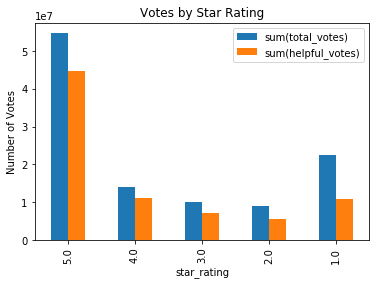

In [15]:
df_clean = df.dropna()
df_clean.plot(x='star_rating', 
              y=['sum(total_votes)', 'sum(helpful_votes)'],
              kind='bar')
plt.ylabel('Number of Votes')
plt.title('Votes by Star Rating');